In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


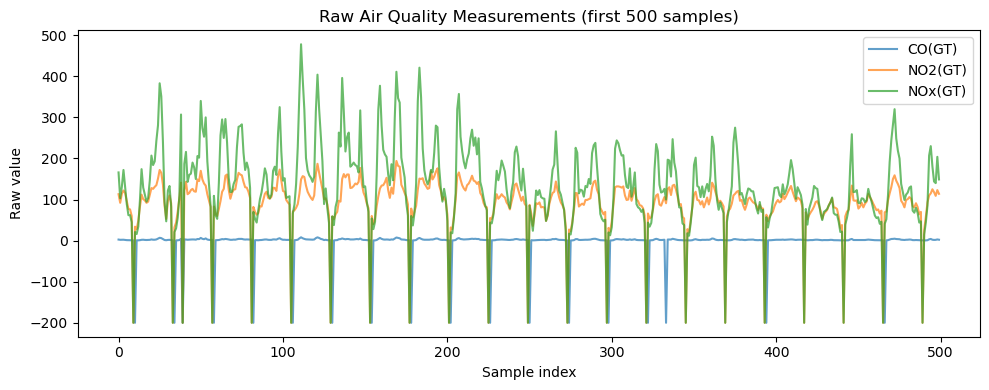

In [13]:
df = pd.read_csv('AirQuality.csv', sep=';', decimal=',')

plt.figure(figsize=(10, 4))
for col in ['CO(GT)', 'NO2(GT)', 'NOx(GT)']:
    if col in df.columns:
        plt.plot(df[col].values[:500], label=col, alpha=0.7)
plt.xlabel('Sample index')
plt.ylabel('Raw value')
plt.title('Raw Air Quality Measurements (first 500 samples)')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
df = df.loc[:, ~df.columns.str.contains('Unnamed')]

df.head(n=15)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
5,10/03/2004,23.00.00,1.2,1197.0,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848
6,11/03/2004,00.00.00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603
7,11/03/2004,01.00.00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702
8,11/03/2004,02.00.00,0.9,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648
9,11/03/2004,03.00.00,0.6,1010.0,19.0,1.7,561.0,-200.0,1705.0,-200.0,1235.0,501.0,10.3,60.2,0.7517


In [4]:
df = df.replace(-200, np.nan)
for col in df.select_dtypes(include=['object']).columns:
    if col not in ['Date', 'Time']:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')


In [5]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df = df.drop(columns=['Date', 'Time'])
df = df.sort_values('Datetime').reset_index(drop=True)


In [6]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    missing_pct = df[col].isna().sum() / len(df)
    if missing_pct > 0.5:
        df = df.drop(columns=[col])
    else:
        df[col] = df[col].fillna(df[col].median())


In [7]:
df['hour'] = df['Datetime'].dt.hour
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month


In [8]:
pollutant_cols = ['NO2(GT)', 'NOx(GT)', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
available_pollutants = [col for col in pollutant_cols if col in df.columns]

df['AQI'] = df[available_pollutants].mean(axis=1)

df['AQI_next_hour'] = df['AQI'].shift(-1)

feature_cols = ['Datetime', 'hour', 'day_of_week', 'month'] + available_pollutants + ['T', 'RH', 'AH', 'AQI_next_hour']
available_feature_cols = [col for col in feature_cols if col in df.columns]

df_clean = df[available_feature_cols].dropna().copy()
df_clean.head()

,Datetime,hour,day_of_week,month,NO2(GT),NOx(GT),C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,AQI_next_hour
0,2004-03-10 18:00:00,18.0,2.0,3.0,113.0,166.0,11.9,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578,769.5500
1,2004-03-10 19:00:00,19.0,2.0,3.0,92.0,103.0,9.4,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255,795.5000
2,2004-03-10 20:00:00,20.0,2.0,3.0,114.0,131.0,9.0,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502,813.2750
3,2004-03-10 21:00:00,21.0,2.0,3.0,122.0,172.0,9.2,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867,770.8125
4,2004-03-10 22:00:00,22.0,2.0,3.0,116.0,131.0,6.5,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888,726.9625


In [9]:
df_clean.to_csv('justin_clean_airquality.csv', index=False)
